In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
%cd /content/drive/MyDrive/ANN2DL_HW2_Shared

/content/drive/MyDrive/ANN2DL_HW2_Shared


In [89]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [67]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [68]:
x_file_path = "./original_data/x_train.npy"
y_file_path = "./original_data/y_train.npy"

X = np.load(x_file_path)
y = np.load(y_file_path)

In [92]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
n_dimensions = X_train.shape[2]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1943, 36, 6), (1943,), (486, 36, 6), (486,))

In [74]:
label_mapping = {
    "Wish",
    "Another",
    "Comfortably",
    "Money",
    "Breathe",
    "Time",
    "Brain",
    "Echoes",
    "Wearing",
    "Sorrow",
    "Hey",
    "Shine"
}

In [70]:
def normalize(X_train, axis, norm_type='no_norm'):
  axs = [0,1,2]
  axs.remove(axis)
  axs=tuple(axs)

  means = np.mean(X_train, axis=axs)
  stds = np.std(X_train, axis=axs)
  mins = np.min(X_train, axis=axs)
  maxs = np.max(X_train, axis=axs)

  params = {
      "means": means,
      "stds": stds,
      "mins": mins,
      "maxs": maxs
  }
  
  if norm_type=='standard':
    X_std_train = []
    
    for i in range(X_train.shape[axis]):
      data = np.take(X_train, i, axis=axis)
      data = (data - means[i]) / stds[i]
      X_std_train.append(data)

    X_std_train = tuple(X_std_train)
    X_std_train = np.stack(X_std_train, axis=axis)

    return X_std_train, params


  elif norm_type=='minmax':
    X_norm_train = []
    
    for i in range(X_train.shape[axis]):
      data = np.take(X_train, i, axis=axis)
      data = (data - mins[i]) / (maxs[i] - mins[i])
      X_norm_train.append(data)

    X_norm_train = tuple(X_norm_train)
    X_norm_train = np.stack(X_norm_train, axis=axis)

    return X_norm_train, params

  else:
    return X_train, params




In [71]:
def normalize_test(X, params, axis, norm_type='no_norm'):
  
  if norm_type=='standard':
    X_std_val = []

    means = params["means"]
    stds = params["stds"]
    mins = params["mins"]
    maxs = params["maxs"]

    for i in range(X.shape[axis]):
      data = np.take(X, i, axis=axis)
      data = (data - means[i]) / stds[i]
      X_std_val.append(data)

    X_std_val = tuple(X_std_val)
    X_std_val = np.stack(X_std_val, axis=axis)

    return X_std_val

  elif norm_type=='minmax':
    X_norm_val = []
    
    for i in range(X.shape[axis]):
      data = np.take(X, i, axis=axis)
      data = (data - mins[i]) / (maxs[i] - min)
      X_norm_val.append(data)

    X_norm_val = tuple(X_norm_val)
    X_norm_val = np.stack(X_norm_val, axis=axis)

    return X_norm_val

  else:
    return X

In [72]:
axis = 2
n_t = 'standard'

X_train, p = normalize(X_train, axis, norm_type=n_t)
X_val = normalize_test(X_val, p, axis, norm_type=n_t)

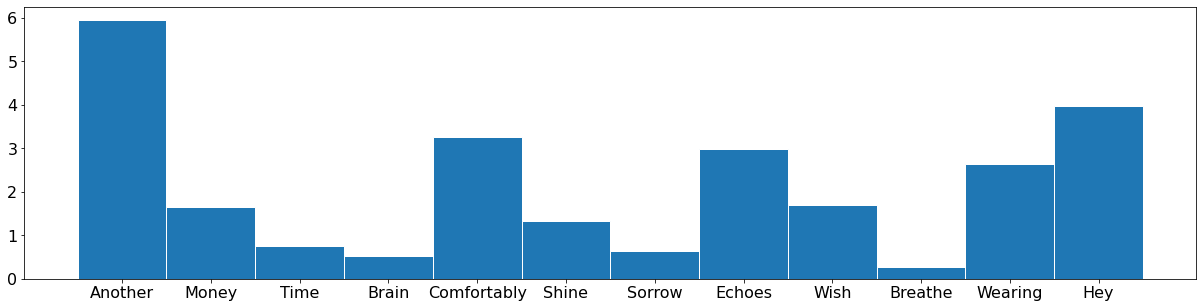

In [82]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

fig = plt.figure(figsize=(21, 5))
plt.bar(np.arange(12), class_weights, width=1, edgecolor="white", tick_label=list(label_mapping))
plt.show()

In [83]:
class_weights = dict(zip(np.arange(12), class_weights))
class_weights

{0: 5.953431372549019,
 1: 1.6456639566395663,
 2: 0.7496913580246913,
 3: 0.5312773403324584,
 4: 3.264784946236559,
 5: 1.3229847494553377,
 6: 0.6466986155484558,
 7: 2.9767156862745097,
 8: 1.6868055555555554,
 9: 0.2605105105105105,
 10: 2.628787878787879,
 11: 3.968954248366013}

In [75]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_train.shape, y_val.shape

((1943, 12), (486, 12))

In [76]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name, experiments_name):

  exps_dir = os.path.join(experiments_name)
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  return callbacks

In [77]:
def build_classifier(input_shape, classes, model_name, lr=0.001):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,5,padding='same',activation='relu')(input_layer) # we will have the same samples in the next layer, we dont loose the temporality
    cnn = tfkl.MaxPooling1D()(cnn)

    cnn = tfkl.Conv1D(256,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)

    cnn = tfkl.Conv1D(256,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)

    cnn = tfkl.Conv1D(256,5,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(gap)
    
    output_layer = tfkl.Dense(12, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name=model_name)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics='accuracy')

    # Return the model
    return model

In [78]:
model_name = "Conv1D_with_std_norm_axis_2"
experiments_name = "Weighted_loss_normalization"

input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

patience1 = 25
patience_plateau = 5
min_lr = 1e-5
lr_factor = 0.5

In [79]:
model = build_classifier(input_shape, classes, model_name)
model.summary()

Model: "Conv1D_with_std_norm_axis_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 36, 128)           3968      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 256)           164096    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 9, 256)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 9, 

In [80]:
%cd ./andrea/Conv1D

/content/drive/MyDrive/ANN2DL_HW2_Shared/andrea/Conv1D


In [84]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name, experiments_name)
cbs.append([tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience1, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=patience_plateau, factor=lr_factor, min_lr=min_lr)])

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = cbs,
    class_weight = class_weights
).history

Epoch 1/200
16/16 [==============================] - 2s 54ms/step - loss: 2.4664 - accuracy: 0.0422 - val_loss: 2.4102 - val_accuracy: 0.2037 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 0s 26ms/step - loss: 2.2930 - accuracy: 0.2928 - val_loss: 2.3778 - val_accuracy: 0.3395 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 0s 27ms/step - loss: 2.1998 - accuracy: 0.3562 - val_loss: 2.2149 - val_accuracy: 0.3745 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 0s 25ms/step - loss: 2.1024 - accuracy: 0.2856 - val_loss: 2.2102 - val_accuracy: 0.1132 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 0s 26ms/step - loss: 2.0763 - accuracy: 0.1199 - val_loss: 2.1645 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 0s 29ms/step - loss: 1.9030 - accuracy: 0.3788 - val_loss: 1.9853 - val_accuracy: 0.4280 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 0s 27ms/step - lo

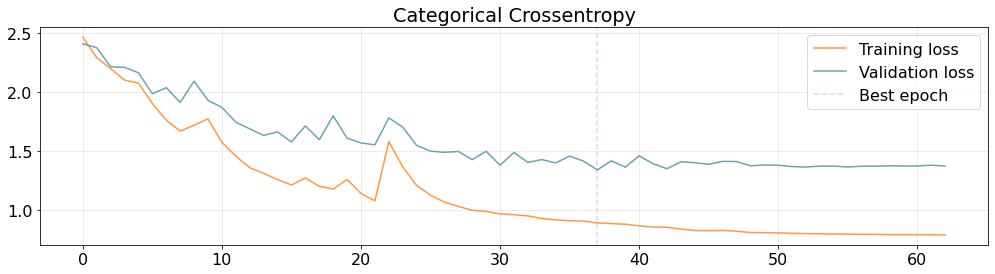

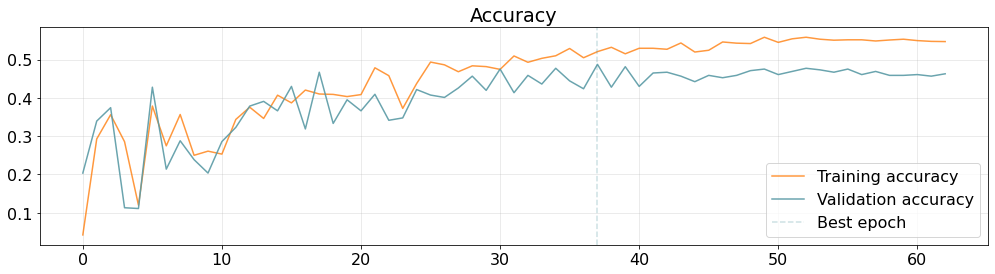

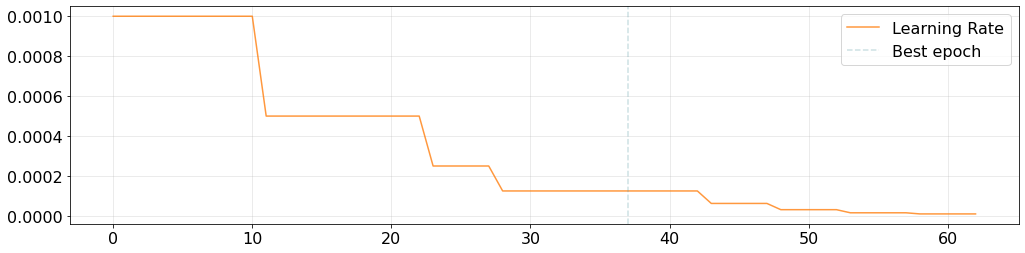

In [85]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [86]:
# Predict the test set with the RNN
predictions = model.predict(X_val)
predictions.shape

16/16 [==============================] - 0s 7ms/step


(486, 12)

Accuracy: 0.4877
Precision: 0.5018
Recall: 0.5789
F1: 0.4969


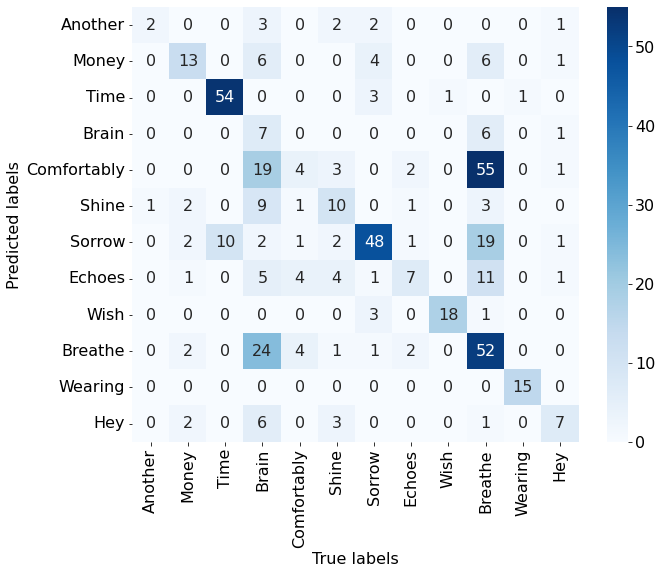

In [87]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping), yticklabels=list(label_mapping), annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

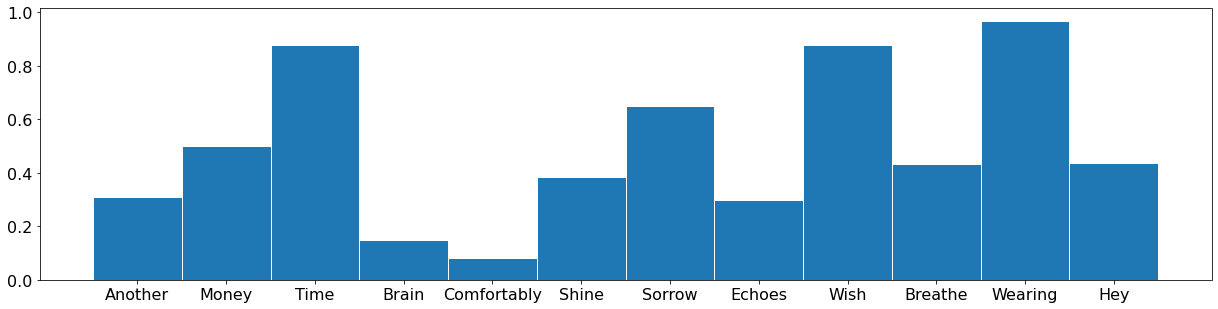

In [88]:
f1s = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)

fig = plt.figure(figsize=(21, 5))
plt.bar(np.arange(12), f1s, width=1, edgecolor="white", tick_label=list(label_mapping))

plt.show()

In [ ]:
#model.save(model_name)
# model = tfk.models.load_model(model_name)